# Описание проекта

Аналитика интернет-магазина. Существует список гипотез для увеличения выручки. 

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.


ЧАСТЬ 1. 

Приоритизация гипотез.

Существует 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

•	Hypothesis — краткое описание гипотезы;


•	Reach — охват пользователей по 10-балльной шкале;


•	Impact — влияние на пользователей по 10-балльной шкале;


•	Confidence — уверенность в гипотезе по 10-балльной шкале;


•	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


In [1]:
# распаковка и вывод на экран таблицы с гипотезами

import pandas as pd

data_h = pd.read_csv('/datasets/hypothesis.csv', sep=',')
pd.set_option('display.max_colwidth', 1000)

display(data_h)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приоритизация гипотез проводится методами ICE и RICE. Расчёт по соответствующим формулам:



# $$ICE = \frac{Impact * Confidence}{Efforts}$$

# $$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [30]:
# приоритизация гипотез методом ICE

data_h['ICE'] = round((data_h['Impact'] * data_h['Confidence'])/data_h['Efforts'])

print(data_h[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

  Hypothesis   ICE
8  Запуст...  16.0
0  Добави...  13.0
7  Добави...  11.0
6  Показа...   8.0
2  Добави...   7.0
1  Запуст...   2.0
3  Измени...   1.0
4  Измени...   1.0
5  Добави...   1.0


In [29]:
# приоритизация гипотез методом RICE

data_h['RICE'] = (data_h['Reach'] * data_h['Impact'] * data_h['Confidence'])/data_h['Efforts']

print(data_h[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))


  Hypothesis   RICE
7  Добави...  112.0
2  Добави...   56.0
0  Добави...   40.0
6  Показа...   40.0
8  Запуст...   16.2
3  Измени...    9.0
1  Запуст...    4.0
5  Добави...    4.0
4  Измени...    3.0


Приоритетные гипотезы по методу ICE: 

8. Запустить акцию, дающую скидку на товар в день
0.  Добавить два новых канала привлечения трафика
7.  Добавить форму подписки на все основные страницы 

Приоритетные гипотезы по методу RICE:

7.  Добавить форму подписки на все основные страницы
2.  Добавить блоки рекомендаций товаров на сайт
0.  Добавить два новых канала привлечения трафика

КОММЕНТАРИИ к расчётам приоритизации гипотез методами ICE и RICE.

Результаты расчётов разные для  разных методов. При примемнении метода ICE самой важной задачей (наиболее значимой гипотезой) является гипотеза номер 8, далее гипотеза номер 0 и номер 7.
При примемнении метода RICE гипотеза номер 8 оказывается лищь на пятом месте по значимости, апервые три по значимости гипотезы это - номер 7, номер 2, номер 0.

Разница результатов объясняется тем, что при расчёте (приоритизации) методом ICE не учитывается параметр Reach - охват пользователей, т.е., при оценке гипотезы не учитывается число пользователей, на которых потенциально рассчитано изменение, описаное в гипотезе.


ЧАСТЬ 2. 

Анализ результатов проведённого A/B-теста. Описание исходных данных.


Таблица orders содержит столбцы: 


•	transactionId — идентификатор заказа;


•	visitorId — идентификатор пользователя, совершившего заказ;


•	date — дата, когда был совершён заказ;


•	revenue — выручка заказа;


•	group — группа A/B-теста, в которую попал заказ.



Таблица visitors содержит столбцы: 


•	date — дата;


•	group — группа A/B-теста;


•	visitors — количество пользователей в указанную дату в указанной группе A/B-теста.



In [4]:
# распаковка и вывод на экран таблицы orders

import scipy.stats as stats
import datetime as dt
import numpy as np

orders = pd.read_csv('/datasets/orders.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

display(orders)
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [5]:
# распаковка и вывод на экран таблицы visitors

visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

display(visitors)
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


В выведенных исходных таблицах видно:

- тест проводился с 1 по 31 августа 2019 года;
- аудитория теста делилась на группы теста А и В;
- даты в обеих таблицах записаны единообразным форматом;
- в столбце revenue таблицы orders есть выбросы;
- данные представлены в корректных форматах;
- пропусков в данных нет.



In [6]:
# подсчёт количества пользователей, попавших в группы теста А и В одновременно

users_2 = orders.groupby('visitorId').agg({'group':'nunique'})
users_2 = users_2.query('group > 1')

print('Пользователей, попавших в группы теста А и В одновременно:', users_2['group'].count())

display(users_2.head())

Пользователей, попавших в группы теста А и В одновременно: 58


,group
visitorId,
8300375,2
199603092,2
232979603,2
237748145,2
276558944,2


В группах теста присутствуют пользователи, попавшие одновременно в обе группы, т.е. и в А, и в В одновременно.

Таких пользователей 58 человек. 

In [7]:
# создание датафрейма datesGroups с уникальными парами значений 'date' и 'group', таблицы orders 
# исключение дубликатов

datesGroups = orders[['date','group']].drop_duplicates() 

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])].agg({
                                    'date' : 'max',
                                    'group' : 'max',
                                    'transactionId' : pd.Series.nunique,
                                    'visitorId' : pd.Series.nunique,
                                    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                    visitors['group'] == x['group'])].agg({
                                    'date' : 'max',
                                    'group' : 'max',
                                    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
                                      
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'],
                                        right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# вывод таблицы, содержащей данные, разбитые по группам А и В на каждое число месяца
display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


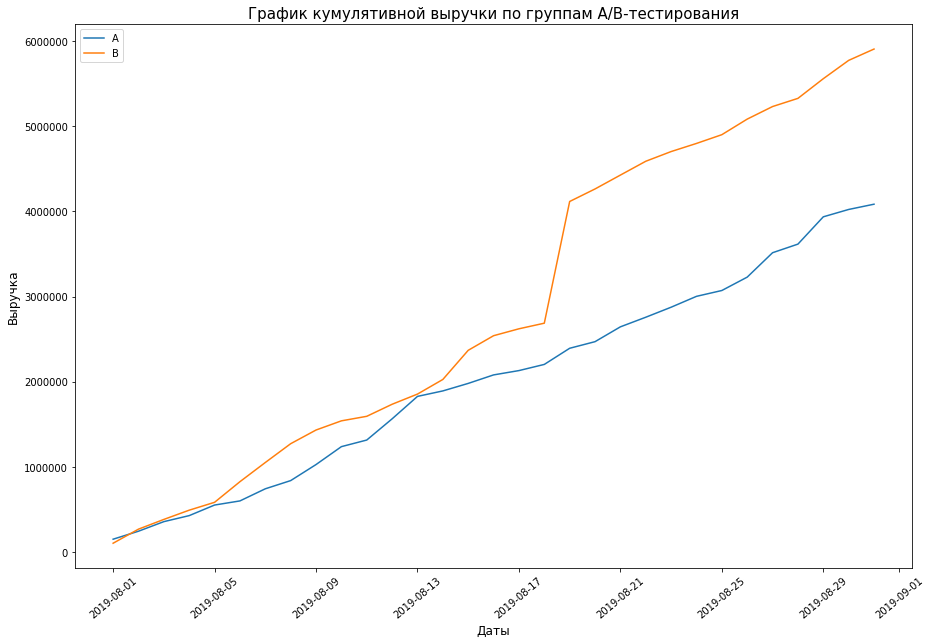

In [39]:
# построение графиков кумулятивной выручки по группам

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# построение графика выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# построение графика выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=40)
plt.rcParams["figure.figsize"] = (15, 10)
plt.legend()
plt.title('График кумулятивной выручки по группам A/B-тестирования', fontsize=15)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.show()




Примерно первую треть выручка группы В растёт примерно с той же скоростью, что и выручка группы А. Сильный отрыв в пользу группы В произошёл единоразовым скачком - свидетельство крупной покупки, исказившей результат. 



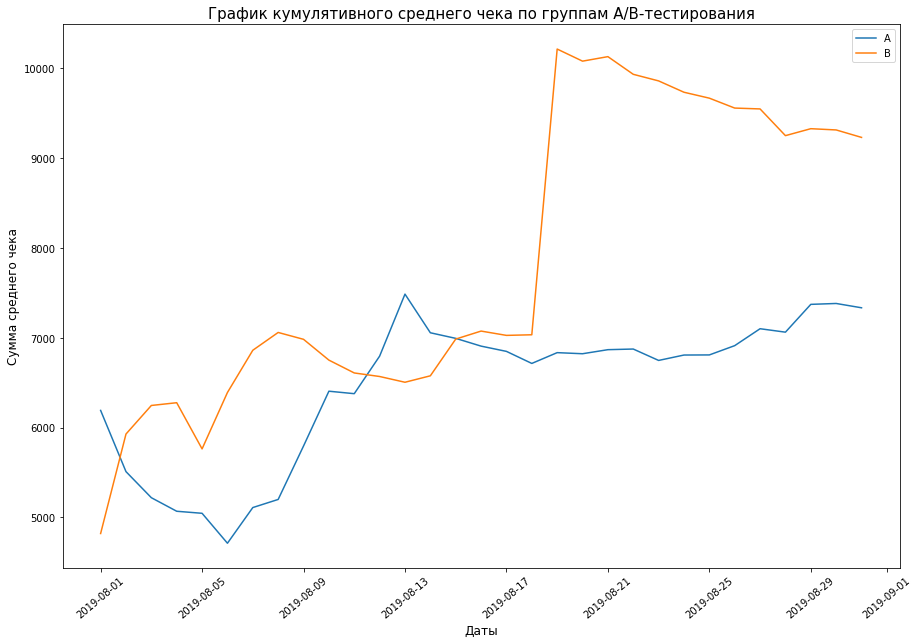

In [38]:
# график кумулятивного среднего чека по группам

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'],
         label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'],
         label='B')
plt.xticks(rotation=40)
plt.legend()
plt.rcParams["figure.figsize"] = (15, 10)
plt.title('График кумулятивного среднего чека по группам A/B-тестирования', fontsize=15)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Сумма среднего чека', fontsize=12)
plt.show()

Графики кумулятивного среднего чека по группам разнились, но принципиально не отличались до единоразового скачка, упомянутого выше. Вероятно, единоразовая крупная покупка пользователя из группы В резко повысила кумулятивный средний чек, что исказило результат.

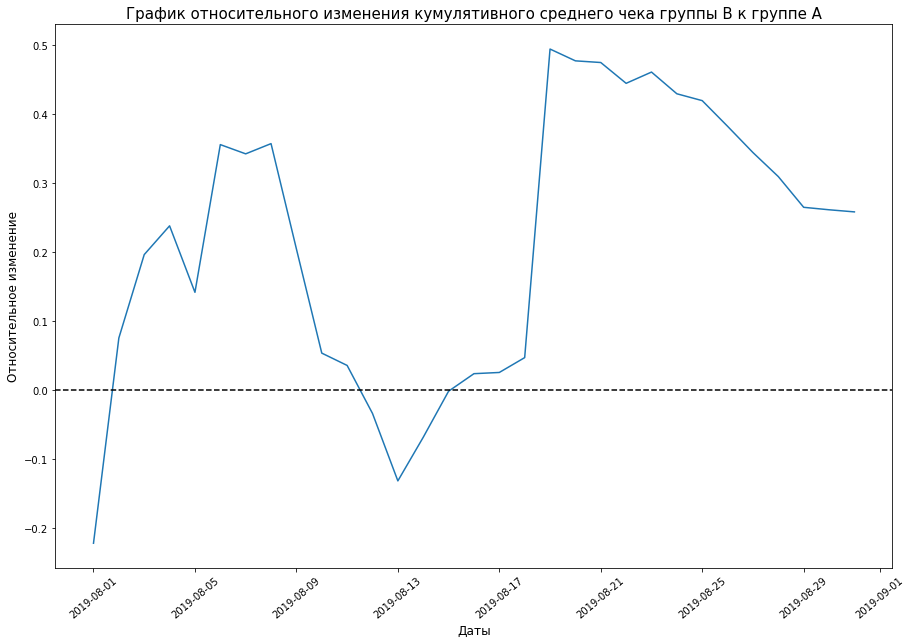

In [37]:
# график относительного изменения кумулятивного среднего чека группы B к группе A

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date',
                                                   right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=40)
plt.rcParams["figure.figsize"] = (15, 10)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A',
          fontsize=15)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.show()

На графике относительного изменения кумулятивного среднего чека группы B к группе A две точки (даты) резкого изменения направления. Резкое падение, что не сильно отразилось на предыдущих графиках, и резкий рост, что отмечено выше, и по-видимому, является свидетельством разовой крупной покупки.

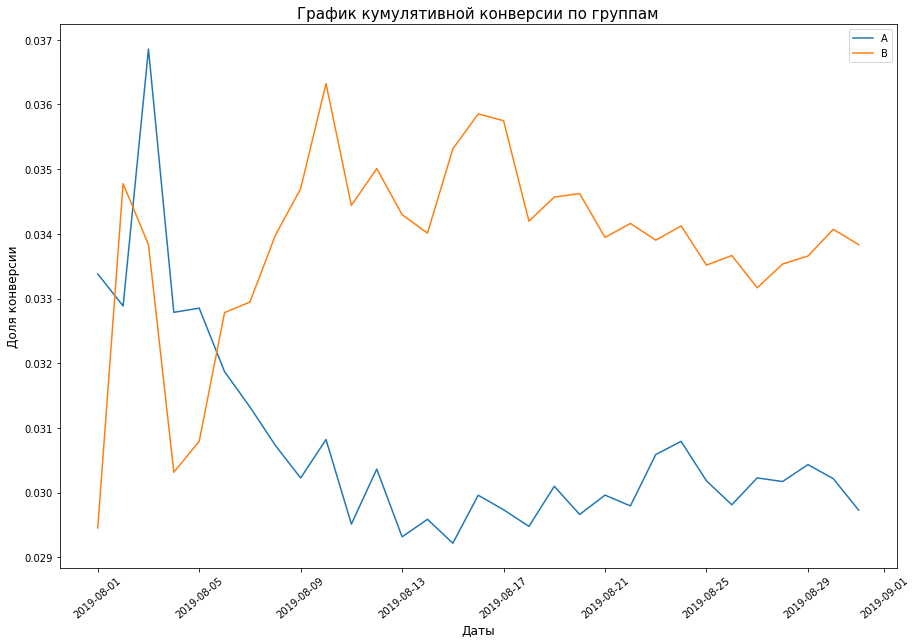

In [36]:
# график кумулятивной конверсии по группам

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.rcParams["figure.figsize"] = (15, 10)
plt.title('График кумулятивной конверсии по группам', fontsize=15)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Доля конверсии', fontsize=12)
plt.xticks(rotation=40)
plt.show()

После колебаний первых дней наблюдения, графики кумулятивных конверсий групп А и В стабилизировались.


К концу теста кумулятивная конверсия группы В выше кумулятивной конверсии группы А примерно на 0,4-0,5%

No handles with labels found to put in legend.


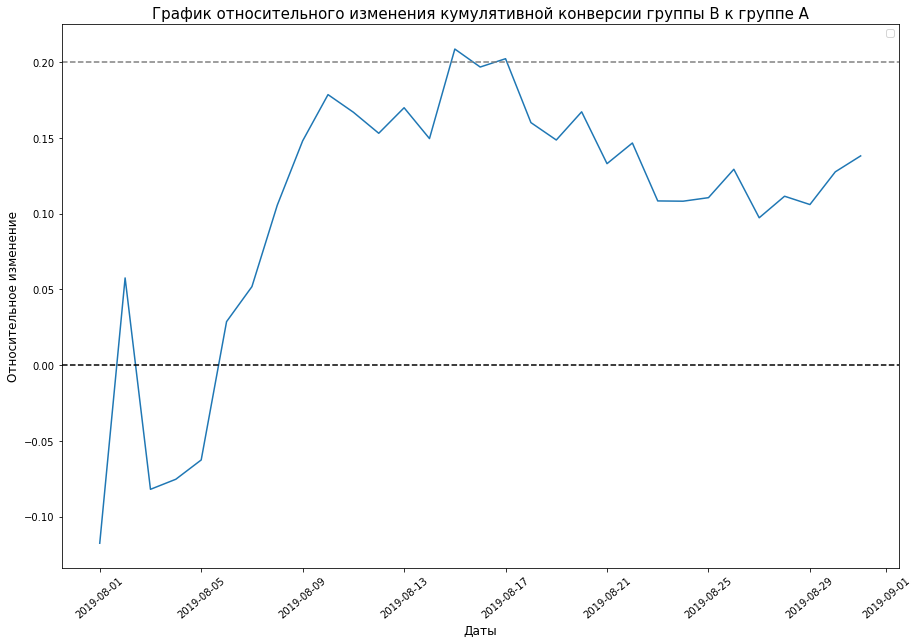

In [35]:
# график относительного изменения кумулятивной конверсии группы B к группе A

mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks(rotation=40)
plt.rcParams["figure.figsize"] = (15, 10)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A',
          fontsize=15)
plt.xlabel('Даты', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.show()

График относительного изменения кумулятивной конверсии группы B к группе A также свидетельствует об установившемся отличии кумулятивной конверсии группы B к группе A.

Относительное изменение кумулятивной конверсии группы B к группе A составляет около 15%.

In [13]:
# для оценки выбросов по количеству заказов на одного посетителя сайта считаю число заказов
# на каждого посетителя, определяю максимальное количество заказов

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

display(ordersByUsers.sort_values(by='transactionId', ascending=False).head(10))

,visitorId,transactionId
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


В течение одного месяца двое посетителей совершили по 11 заказов - это максимальное 
количество заказов в имеющихся данных.

Далее определяю, насколько это типично.

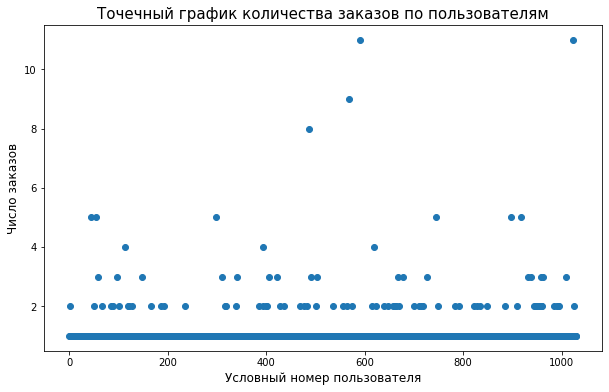

In [41]:
# построение точечного графика количества заказов по пользователям

x_values = pd.Series(range(0,len(ordersByUsers['transactionId'])))

plt.scatter(x_values, ordersByUsers['transactionId'])
plt.rcParams["figure.figsize"] = (8, 5)
plt.title('Точечный график количества заказов по пользователям',
          fontsize=15)
plt.xlabel('Условный номер пользователя', fontsize=12)
plt.ylabel('Число заказов', fontsize=12)
plt.show()

Точечный график количества заказов по пользователям показывает, что граница выбросов лежит между значениями 3 и 5. Большее количество заказов встречается значительно реже.

In [15]:
print(np.percentile(ordersByUsers, [95, 99])) 

[3.87010466e+09 4.18972491e+09]


Определение 95 и 99 перцентилей количества заказов на одного посетителя сайта дало такие результаты:


не более 5% посетителей совершило более 3,87 заказа;


не более 1% посетителей совершило более 4,19 заказа. 


Т.е. граница аномального количества заказов - 4. Количество заказов более 4-ёх - аномально, и признаётся выбросом.

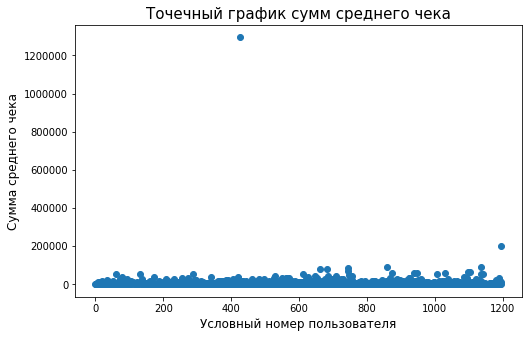

In [42]:
# построение точечного графика сумм среднего чека

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.title('Точечный график сумм среднего чека',
          fontsize=15)
plt.xlabel('Условный номер пользователя', fontsize=12)
plt.ylabel('Сумма среднего чека', fontsize=12)
plt.show()

Точечный график стоимостей заказов демонстрирует два ярко выделяющихся выброса - покупка примерно 200 000 ед., и покупка более, чем 1 200 000 ед. Это второе значение в столбце revenue очень сильно искажает результаты анализа данных. Вероятно, это событие вызывает скачкообразное изменение графиков:
графика кумулятивной выручки по группам, графика кумулятивного среднего чека по группам, графика относительного изменения кумулятивного среднего чека группы B к группе A. Также, эта покупка изменяет масштаб и точечного графика, из-за чего наглядность графика сильно страдает.

In [17]:
# оценка выбросов в столбце revenue таблицы orders - выбросы по среднему чеку

print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Определение 95 и 99 перцентилей среднего чека (revenue таблицы orders) дало такие результаты:

Не более 5% заказов дороже 28 000 ед. и не более 1% дороже 58 233 ед.

За границу аномальных заказов принимаю 28 000 ед.

Для исключения искажений результатов анализа А/В теста необходимо исключить из дальнейших расчётов аномальные значения - выбросы. Принимаю за границу выбросов:

* средний чек - не более 28 000;
* количество совершённых заказов - не более 4-ёх

In [18]:
# составление таблицы со всеми данными на каждый день для обеих групп

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)

visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [

    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# вывод таблицы со всеми данными на каждый день для обеих групп

display(data.head())


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Далее проведён расчёт статистических значимостей различий метрик между группами А и В. Результатами расчётов выступают полученные значения p-value и рассчитанное значение относительного изменения метрики одной группы по отношению к другой.

Для верной интерпретации результатов необходимо задать уровень p-value и сформулировать проверяемые гипотезы.

Задаю p-value = 0,05


Формулирую гипотезы


* Нулевая гипотеза 


H0: данные в выборках (группах А и В) взяты из одной и той же генеральной совокупности, т.е., различий между группами А и В нет.

* Альтернативная гипотеза


H1: данные в выборках (группах А и В) взяты из разных генеральных совокупностей, т.е., есть значимые различия между группами А и В.



In [19]:
# подсчёт статистической значимости различий в конверсии между группами А и В по «сырым» данным

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('Значение p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие конверсий в долях составляет:',
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


Значение p-value: 0.008
Относительное различие конверсий в долях составляет: 0.138


Если вести подсчёт по "сырым" данным , при задании р-value = 0.05, полученный результат означает то, что нулевая гипотеза отвергнута, т.е., статистически значимые различия в конверсиях между групп существуют. В пользу этого вывода говорит полученное значение относительного различия конверсий - 13,8%.

In [20]:
# расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

print('Значение p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие в среднем чеке заказа между группами в долях составляет:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


Значение p-value: 0.365
Относительное различие в среднем чеке заказа между группами в долях составляет: 0.259


Результаты расчёта статистической значимости различий в среднем чеке заказа между группами по «сырым» данным парадоксальны.

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
При этом, относительное различие в среднем чеке заказа между группами составляет почти 26%.

Вероятно, характер результатов объясняется искажениями вследствие наличия единоразовых крупных заказов, отмеченных выше.

In [21]:
# расчёт статистической значимости различий в конверсии между группами по «очищенным» данным

# фильтрация данных: исключение пользователей, совершивших более 4 заказов за время теста (1 месяц),
# и исключение заказов, стоимостью более 28 000 ед.

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


In [22]:
# расчёт статистической значимости различий в конверсии между группами по «очищенным» данным

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 


print('Значение p-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие конверсий в долях составляет:',
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Значение p-value: 0.009
Относительное различие конверсий в долях составляет: 0.145


Подсчёт по "очищенным" данным , при задании р-value = 0.05, также отвергает нулевую гипотезу, т.е., статистически значимые различия в конверсиях между групп существуют. Также, это снова подтверждает полученное значение относительного различия конверсий - 14,5%.


In [23]:
# расчёт и вывод статистической значимости различий в среднем чеке заказа 
# между группами по «очищенным» данным

print('Значение p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие в среднем чеке заказа между группами в долях составляет:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


Значение p-value: 0.481
Относительное различие в среднем чеке заказа между группами в долях составляет: -0.014


Результаты расчёта статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным сильно отличаются от результата расчётов по "сырым" данным.

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
Относительное же различие в среднем чеке заказа между группами составляет всего 1,4% (меньше значения P-value), что хорошо согласуется с полученным значением P-value, и подтверждает предположение о том, что результаты расчётов сильно искажали единоразовые крупные покупки.


# Решение по результатам теста

Расчёт изменения конверсии по группам дал такие результаты (расчёт по "сырым" данным/расчёт по "очищенным" данным): 

Значение p-value: 0.008 / 0.009
Относительное различие конверсий в долях составляет: 0.138 / 0.145

* Результаты расчётов свидетельствуют о значимом расхождении в величине конверсии в пользу группы В. В пользу такого вывода говорят графики расчёта кумулятивной конверсии по группам. Наличие выбросов в данных на результаты расчётов влияет незначительно.

Расчёт изменения суммы среднего чека по группам дал такие результаты (расчёт по "сырым" данным/расчёт по "очищенным" данным): 

Значение p-value: 0.365 / 0.481
Относительное различие в среднем чеке заказа между группами в долях составляет: 0.259 / -0.014

* Результаты расчётов свидетельствуют о незначимом расхождении в сумме среднего чека по группам. На результаты расчётов сильно влияют выбросы. Исключение выбросов из данных нивелирует различия в сумме среднего чека.

___________

* Таким образом, принимается решение остановить тест, зафиксировать победу группы В.
